## Compile log-likelihood function

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hssm

### Simulate Data

In [2]:
obs_ddm = hssm.simulate_data(
    theta={"v": 0.5, "a": 1.5, "t": 0.3, "z": 0.5},
    model="angle",
    size=500,
)

### Basic HSSM model

In [3]:
model = hssm.HSSM(
    data=obs_ddm,
    loglik_kind="analytical",
    process_initvals=True,
    p_outlier=0
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
Model initialized successfully.


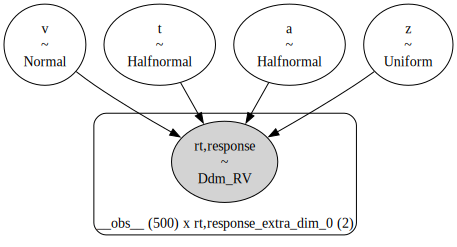

In [4]:
model.graph()

We can now use the `compile_logp()` method to compile the log-likelihood function created by the `hssm`. This illustrates the simplest use case, `compile_logp()` with no additional arguments. 
Check the documentation for more details on how to make `compile_logp()` work for more customized use cases.

In [5]:
logp_fun = model.compile_logp()  # msynth.pymc_model.compile_logp()
print(logp_fun(model.initial_point(transformed=False)))

-33054.449962779865


Note that `logp_fun` takes as input a dictionary of parameter values with keys corresponding to the parameters names
created by `hssm`. It might be helpful to take a look at the `initial_point()` method to see how the parameters are passed.

In [6]:
print(model.initial_point(transformed=False))

{'t': array(2.), 'a': array(2.), 'z': array(0.5), 'v': array(0.)}


##### Timing the compiled log-likelihood function

In [7]:
# time
import time

my_start_point = model.initial_point(transformed=False)
start_time = time.time()
for i in range(1000):
    logp_fun(my_start_point)
print((time.time() - start_time) / 1000)

0.0001394040584564209


### Using the compiled log-likelihood function

For illustration, we use our compile log-likelihood function with a different MCMC sampler, using the 
[`zeus`](https://github.com/minaskar/zeus) package.

> **Note:** `zeus` is an optional dependency of `hssm` and can be installed using the command `pip install hssm[notebook]`. Alternatively, you can install it directly with `pip install zeus-mcmc`.

#### Wrap the compiled log-likelihood to accomodate `zeus`

In [8]:
def mylogp(theta: list[float]) -> float:
    """Wrap function for compiled log probability function to work with zeus sampler.

    Args
    ----
        theta: List of model parameters [v, a, z, t] where:
            v: Drift rate
            a: Boundary separation
            z: Starting point
            t: Non-decision time

    Returns
    -------
        float: Log probability value for the given parameters
    """
    v, a, z, t = theta
    return logp_fun({"v": v, "a": a, "z": z, "t": t})

#### Test sampling with `zeus`


In [9]:
import zeus

start = np.random.uniform(low=-0.2, high=0.2, size=(8, 4)) + np.tile(
    [0.5, 1.5, 0.5, 0.3], (8, 1)
)
sampler = zeus.EnsembleSampler(8, 4, mylogp)

In [10]:
sampler.run_mcmc(start, 1000)

Initialising ensemble of 8 walkers...
Sampling progress : 100%|██████████| 1000/1000 [00:08<00:00, 118.93it/s]


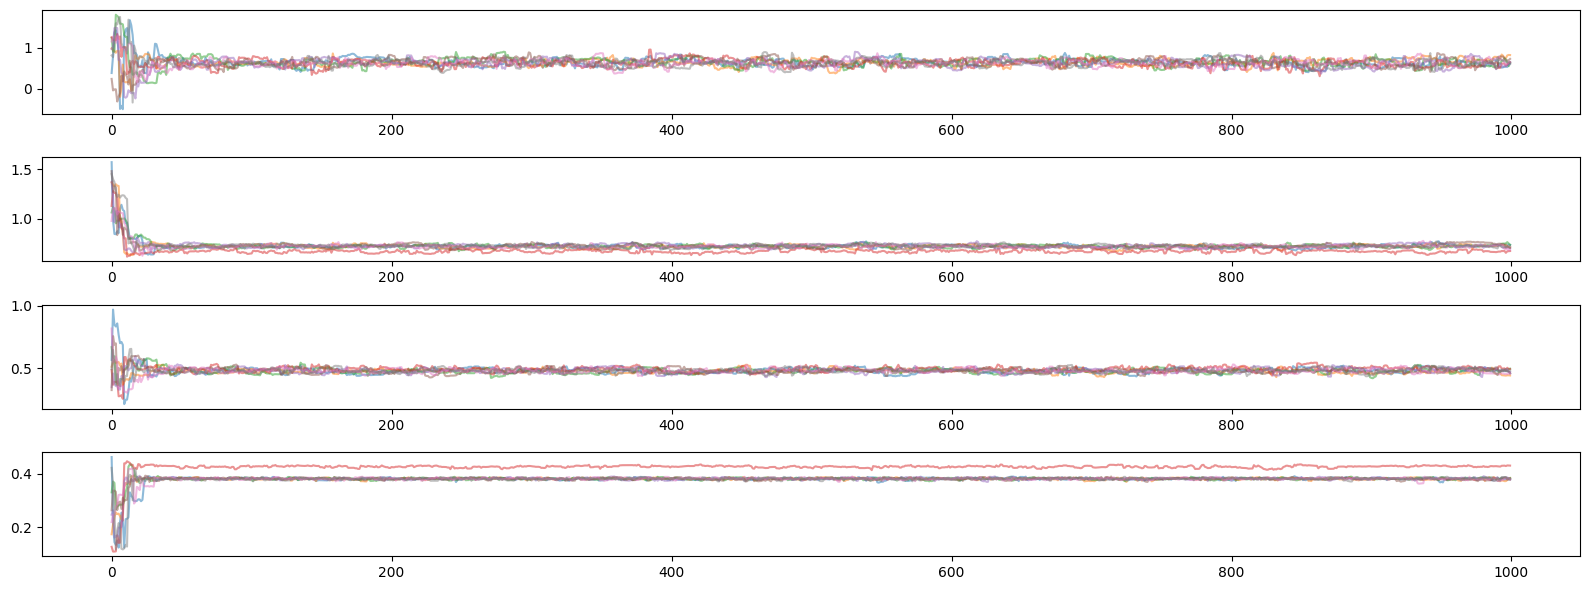

In [11]:
plt.figure(figsize=(16, 1.5 * 4))
for n in range(4):
    plt.subplot2grid((4, 1), (n, 0))
    plt.plot(sampler.get_chain()[:, :, n], alpha=0.5)
plt.tight_layout()
plt.show()